In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 36.9 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path where files will be saved in Google Drive
save_path = '/content/drive/MyDrive/pendulum_training/'

# Create the directory if it doesn't exist
import os
os.makedirs(save_path, exist_ok=True)


Mounted at /content/drive


Episode: 100, Epsilon: 0.95, Best Reward: [-57890.68], Mean Rewards -57406.3


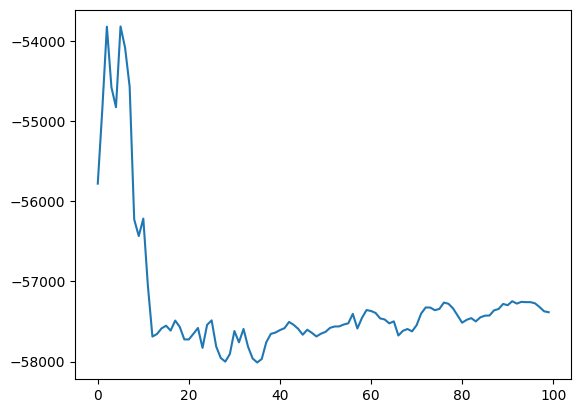

Episode: 200, Epsilon: 0.90, Best Reward: [-50826.44], Mean Rewards -56201.1


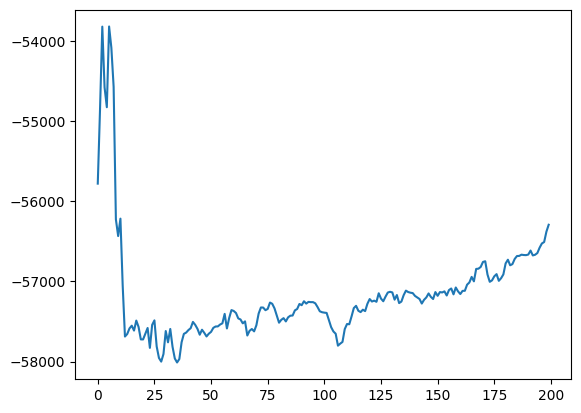

Episode: 300, Epsilon: 0.85, Best Reward: -4.108367847514258, Mean Rewards -49991.1


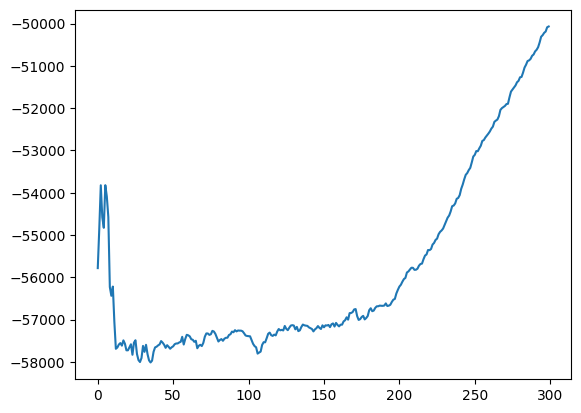

Episode: 400, Epsilon: 0.80, Best Reward: -2.9060657037535362, Mean Rewards -46210.3


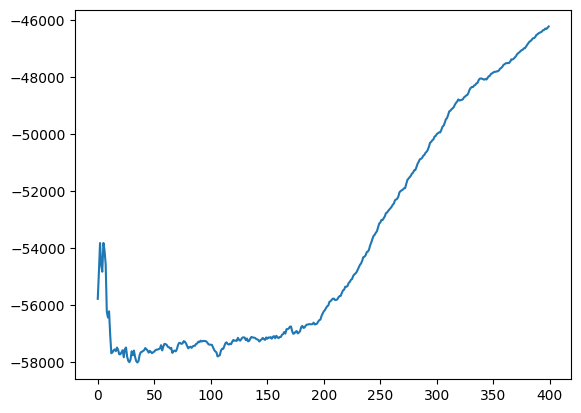

Episode: 500, Epsilon: 0.75, Best Reward: [-41776.074], Mean Rewards -44220.4


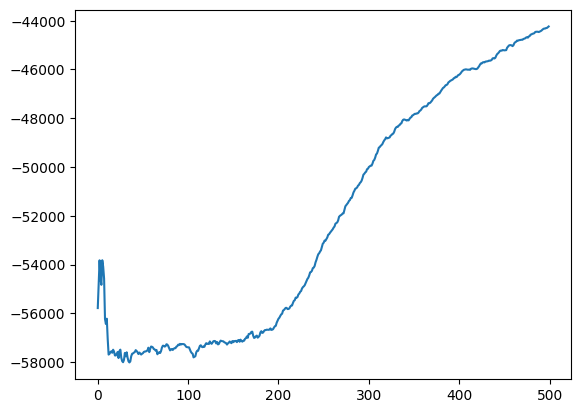

Episode: 600, Epsilon: 0.70, Best Reward: -0.07668975511002445, Mean Rewards -42514.6


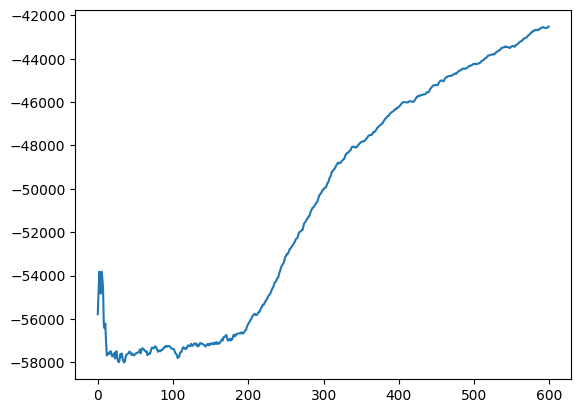

Episode: 700, Epsilon: 0.65, Best Reward: [-40049.523], Mean Rewards -40483.7


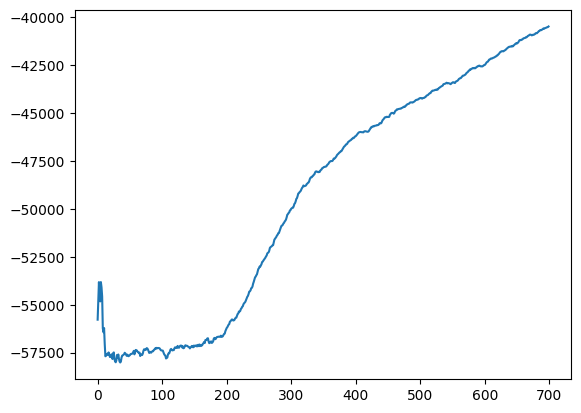

Episode: 800, Epsilon: 0.60, Best Reward: -0.004364969666255667, Mean Rewards -38214.1


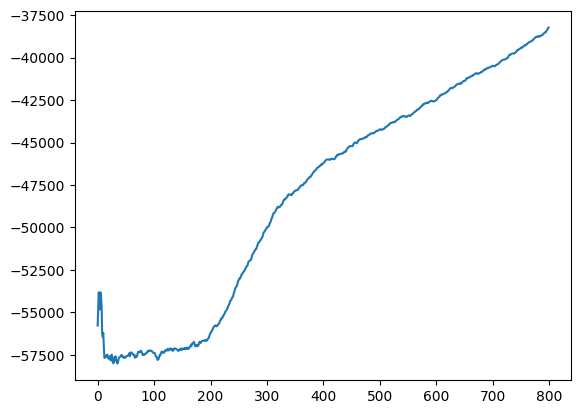

Episode: 900, Epsilon: 0.55, Best Reward: -0.004364969666255667, Mean Rewards -36305.6


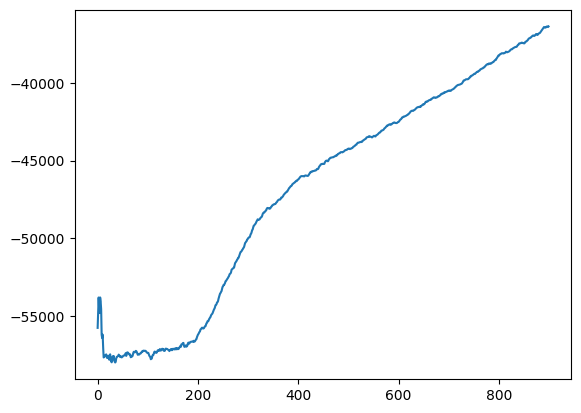

Episode: 1000, Epsilon: 0.50, Best Reward: -0.004364969666255667, Mean Rewards -34153.8


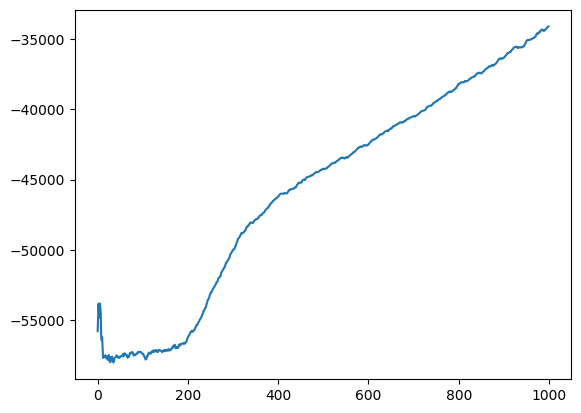

Episode: 1100, Epsilon: 0.45, Best Reward: -0.004364969666255667, Mean Rewards -31853.7


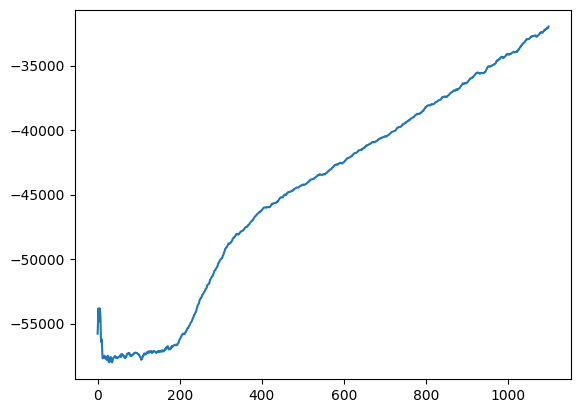

Episode: 1200, Epsilon: 0.40, Best Reward: -0.004364969666255667, Mean Rewards -28746.4


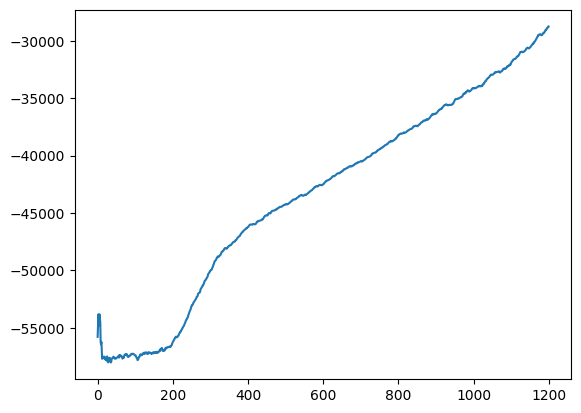

Episode: 1300, Epsilon: 0.35, Best Reward: -0.004364969666255667, Mean Rewards -25473.6


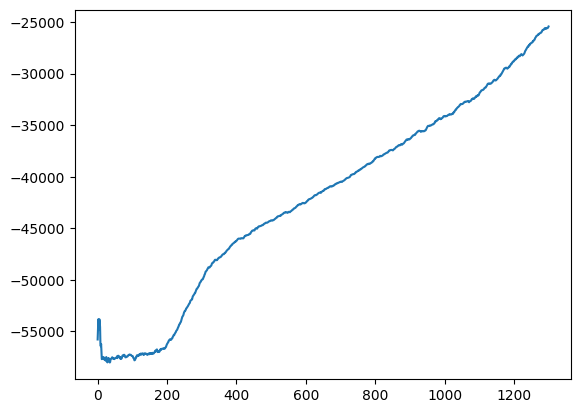

Episode: 1400, Epsilon: 0.30, Best Reward: -0.0018912652412404513, Mean Rewards -21520.6


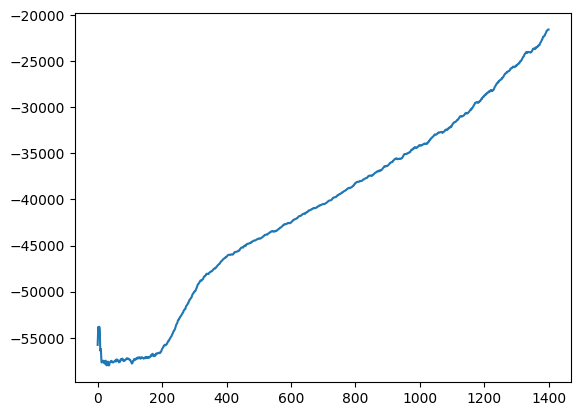

Episode: 1500, Epsilon: 0.25, Best Reward: -0.0018912652412404513, Mean Rewards -16607.8


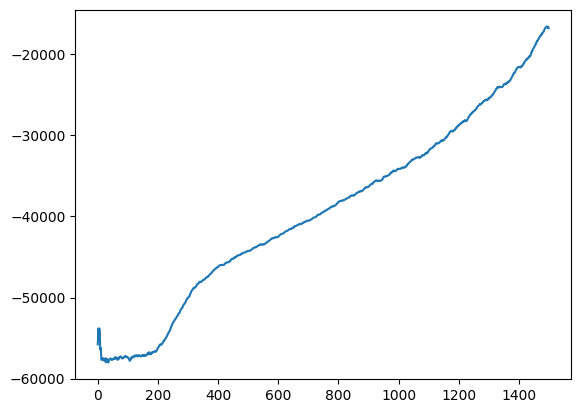

Episode: 1600, Epsilon: 0.20, Best Reward: -0.0018912652412404513, Mean Rewards -13058.5


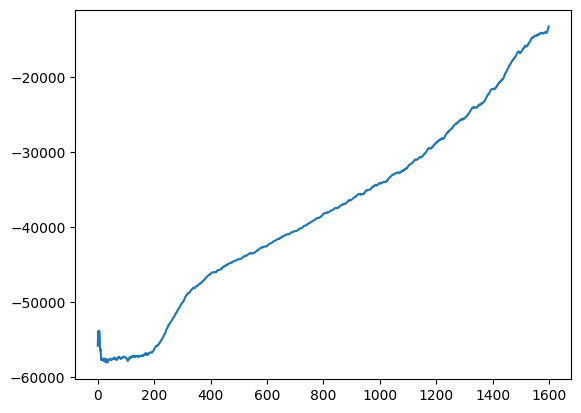

Episode: 1700, Epsilon: 0.15, Best Reward: -0.0018912652412404513, Mean Rewards -8339.8


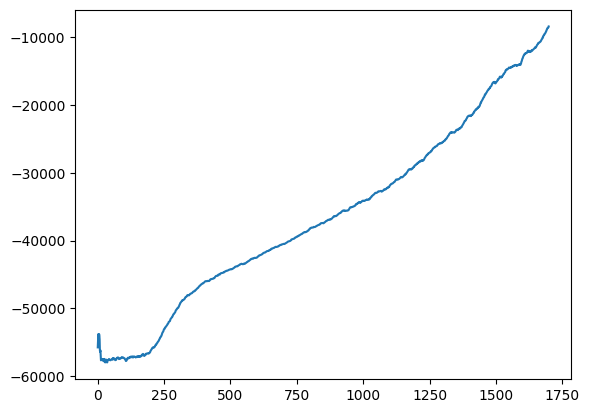

Episode: 1800, Epsilon: 0.10, Best Reward: -0.0018912652412404513, Mean Rewards -3796.0


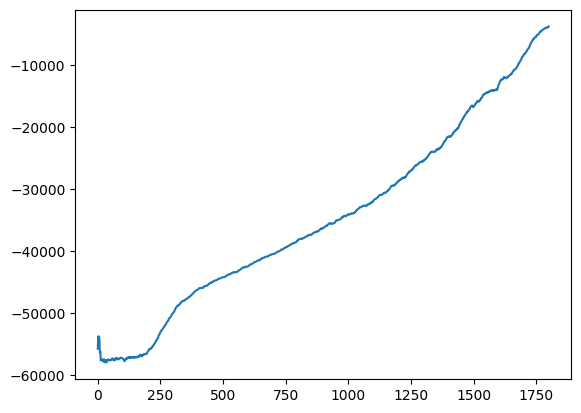

Episode: 1900, Epsilon: 0.05, Best Reward: -0.0018912652412404513, Mean Rewards -2512.6


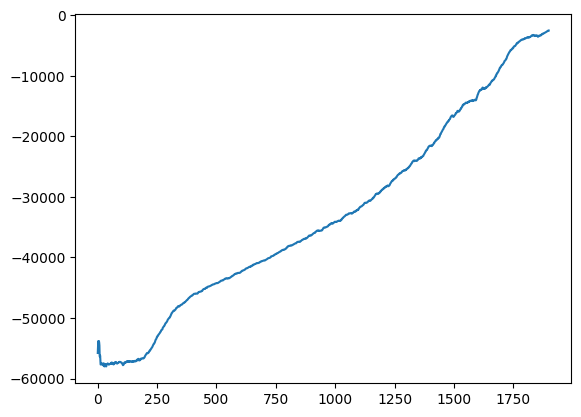

Episode: 2000, Epsilon: 0.05, Best Reward: -0.0018912652412404513, Mean Rewards -1574.6


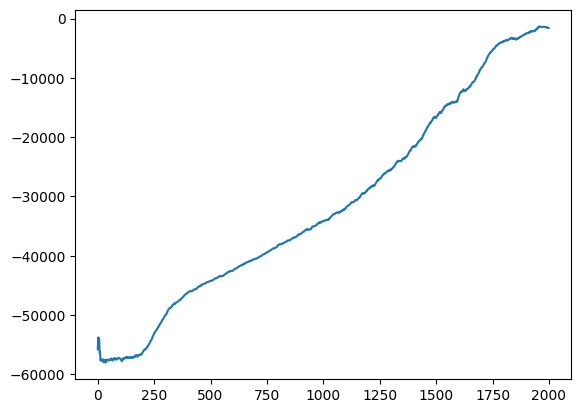

Episode: 2100, Epsilon: 0.05, Best Reward: -0.0018912652412404513, Mean Rewards -1337.6


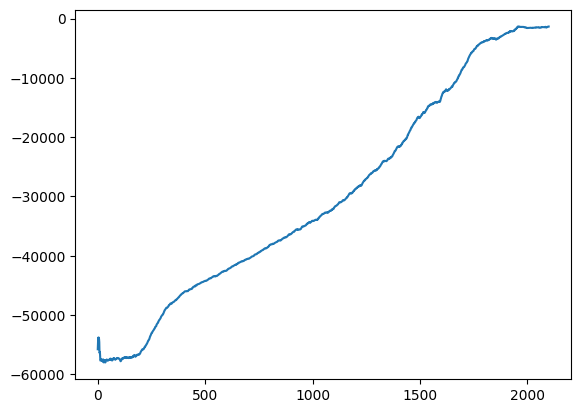

Episode: 2200, Epsilon: 0.05, Best Reward: -0.0018912652412404513, Mean Rewards -1497.5


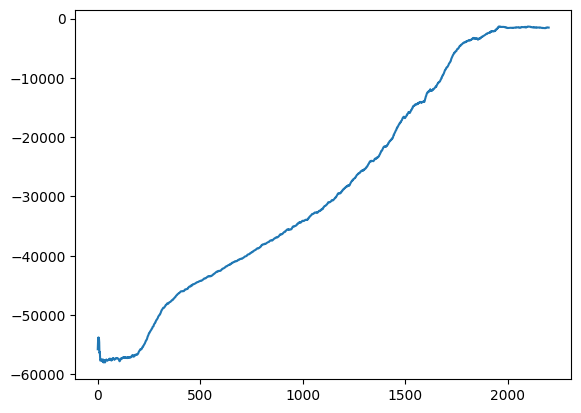

Episode: 2300, Epsilon: 0.05, Best Reward: -0.0018912652412404513, Mean Rewards -1362.8


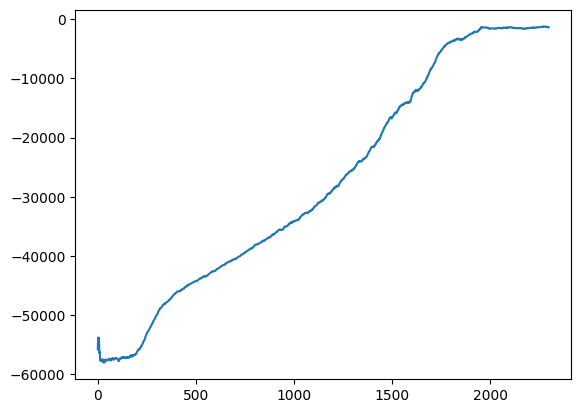

Episode: 2400, Epsilon: 0.05, Best Reward: -0.0018912652412404513, Mean Rewards -1106.4


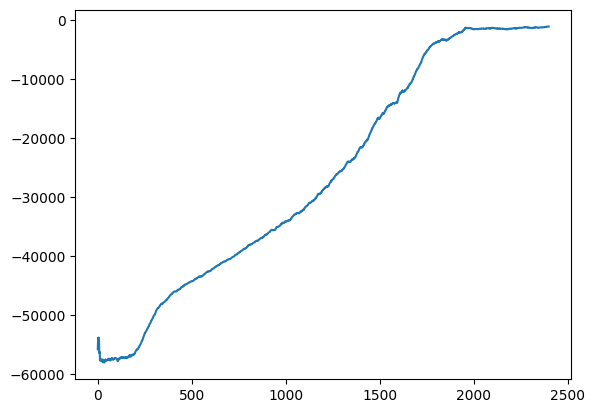

Episode: 2500, Epsilon: 0.05, Best Reward: -0.0018912652412404513, Mean Rewards -1311.6


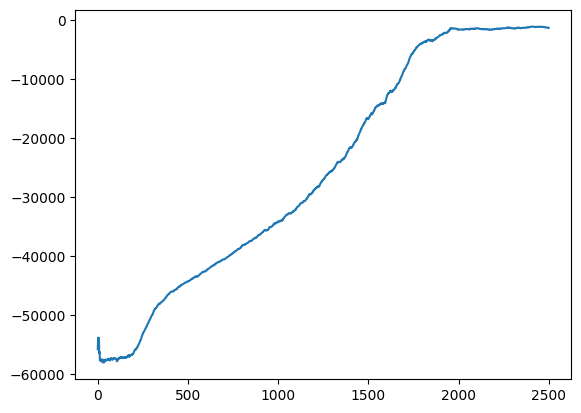

KeyboardInterrupt: 

In [5]:
def run(is_training=True, render=False):
    env = gym.make('Pendulum-v1', render_mode='rgb_array' if render else None)

    # Hyperparameters
    learning_rate_a = 0.1         # Alpha: learning rate
    discount_factor_g = 0.9       # Gamma: discount factor.
    epsilon = 1                   # Start epsilon at 1 (100% random actions)
    epsilon_decay_rate = 0.0005   # Epsilon decay rate
    epsilon_min = 0.05            # Minimum epsilon
    divisions = 15                # Used to convert continuous state space to discrete space

    # Divide observation space into discrete segments
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    w = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)

    # Divide action space into discrete segments
    a = np.linspace(env.action_space.low[0], env.action_space.high[0], divisions)

    # Load or initialize Q-table
    if is_training or not os.path.exists(save_path + 'pendulum.pkl'):
        # Initialize q-table if training or file doesn't exist
        q = np.zeros((len(x) + 1, len(y) + 1, len(w) + 1, len(a) + 1))
    else:
        # Load existing q-table for evaluation
        with open(save_path + 'pendulum.pkl', 'rb') as f:
            q = pickle.load(f)

    best_reward = -99999
    rewards_per_episode = []  # List to store rewards for each episode
    i = 0

    while True:
        state = env.reset()[0]
        s_i0 = np.digitize(state[0], x)
        s_i1 = np.digitize(state[1], y)
        s_i2 = np.digitize(state[2], w)

        rewards = 0
        steps = 0

        while steps < 10000 or not is_training:
            if is_training and np.random.rand() < epsilon:
                # Choose random action
                action = env.action_space.sample()
                action_idx = np.digitize(action, a)
            else:
                action_idx = np.argmax(q[s_i0, s_i1, s_i2, :])
                action = a[action_idx - 1]

            # Take action
            new_state, reward, _, _, _ = env.step([action])
            ns_i0 = np.digitize(new_state[0], x)
            ns_i1 = np.digitize(new_state[1], y)
            ns_i2 = np.digitize(new_state[2], w)

            # Update Q-table
            if is_training:
                q[s_i0, s_i1, s_i2, action_idx] = (
                    q[s_i0, s_i1, s_i2, action_idx] +
                    learning_rate_a * (
                        reward + discount_factor_g * np.max(q[ns_i0, ns_i1, ns_i2, :]) -
                        q[s_i0, s_i1, s_i2, action_idx]
                    )
                )

            state = new_state
            s_i0, s_i1, s_i2 = ns_i0, ns_i1, ns_i2
            rewards += reward
            steps += 1

            if rewards > best_reward:
                best_reward = rewards

                # Save Q-table on new best reward
                if is_training:
                    with open(save_path + 'pendulum.pkl', 'wb') as f:
                        pickle.dump(q, f)

        # Store rewards per episode
        rewards_per_episode.append(rewards)

        # Print stats
        if is_training and i != 0 and i % 100 == 0:
            mean_reward = np.mean(rewards_per_episode[-100:])
            print(f'Episode: {i}, Epsilon: {epsilon:.2f}, Best Reward: {best_reward}, Mean Rewards {mean_reward:.1f}')

            # Plot mean rewards
            mean_rewards = [np.mean(rewards_per_episode[max(0, t - 100):(t + 1)]) for t in range(i)]
            plt.plot(mean_rewards)
            plt.savefig(save_path + 'pendulum_rewards.png')
            plt.show()

        elif not is_training:
            print(f'Episode: {i}, Best Reward: {rewards:.1f}')

        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay_rate, epsilon_min)
        i += 1

        # THIS WHILE LOOP WILL NEVER END. MANUALLY STOP THE TRAINING WHEN THE SOLUTION IS FOUND.

if __name__ == '__main__':
    run(is_training=True, render=False)
    #run(is_training=False, render=False)

I manually interrupted the keyboard as I saw the mean was stabilized and the best reward was not changing ans was around 0, indicating th best configuration was already found

In [6]:
import pickle

# Path to your .pkl file (adjust this path if necessary)
file_path = '/content/drive/MyDrive/pendulum_training/pendulum.pkl'

# Load the .pkl file
with open(file_path, 'rb') as file:
    q_table = pickle.load(file)

# Now `q_table` contains the data from the .pkl file
print(q_table)


[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 

In [50]:
import gymnasium as gym
import numpy as np
import pickle
import os
from google.colab import drive
from IPython.display import HTML, display
import time

# Define paths
save_path = '/content/drive/MyDrive/pendulum_training/'
video_path = save_path + "videos/"
os.makedirs(video_path, exist_ok=True)


# Function to run a simulation using the pre-trained Q-table
def run_simulation():
    # Create the environment with render_mode='rgb_array' for video recording
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(env, video_path, episode_trigger=lambda x: True)

    # Load the Q-table
    q_table_path = save_path + 'pendulum.pkl'
    with open(q_table_path, 'rb') as f:
        q = pickle.load(f)

    # Parameters for discretization
    divisions = 15
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    w = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
    a = np.linspace(env.action_space.low[0], env.action_space.high[0], divisions)

    # Run one episode
    state = env.reset()[0]
    s_i0 = np.digitize(state[0], x)
    s_i1 = np.digitize(state[1], y)
    s_i2 = np.digitize(state[2], w)
    done = False
    steps = 0

    while not done and steps < 1000:
        # Choose the best action based on the Q-table
        action_idx = np.argmax(q[s_i0, s_i1, s_i2, :])
        action = a[action_idx - 1]

        # Take action
        new_state, _, done, _, _ = env.step([action])
        ns_i0 = np.digitize(new_state[0], x)
        ns_i1 = np.digitize(new_state[1], y)
        ns_i2 = np.digitize(new_state[2], w)

        # Update state indices
        s_i0, s_i1, s_i2 = ns_i0, ns_i1, ns_i2
        steps += 1

    env.close()

# Run the simulation
run_simulation()


In [24]:
from IPython.display import HTML
from base64 import b64encode

# Define the path to the video file
video_path = '/content/drive/MyDrive/pendulum_training/videos/rl-video-episode-0.mp4'

# Read and encode the video file
video = open(video_path, "rb").read()
video_encoded = b64encode(video).decode('ascii')

# Display the video
HTML(f"""
<video width="640" height="480" controls>
  <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
</video>
""")


# some metrics

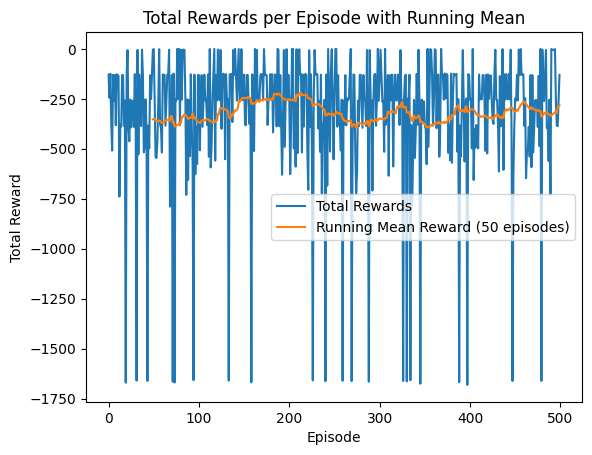

In [52]:
import gymnasium as gym
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

# Define paths
save_path = '/content/drive/MyDrive/pendulum_training/'

# Function to run a simulation using the pre-trained Q-table and collect metrics
def run_simulation(n_eps=500):
    # Create the environment without video recording for metric tracking
    env = gym.make('Pendulum-v1')

    # Load the Q-table
    q_table_path = save_path + 'pendulum.pkl'
    with open(q_table_path, 'rb') as f:
        q = pickle.load(f)

    # Parameters for discretization
    divisions = 15
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    w = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
    a = np.linspace(env.action_space.low[0], env.action_space.high[0], divisions)

    # Metrics storage
    total_rewards = []
    steps_per_episode = []
    q_values_over_time = []

    # Run multiple episodes for analysis
    for episode in range(n_eps):
        state = env.reset()[0]
        s_i0 = np.digitize(state[0], x)
        s_i1 = np.digitize(state[1], y)
        s_i2 = np.digitize(state[2], w)
        done = False
        truncated = False
        steps = 0
        episode_reward = 0

        while not done and not truncated:
            # Choose the best action based on the Q-table
            action_idx = np.argmax(q[s_i0, s_i1, s_i2, :])
            action = a[action_idx - 1]

            # Record Q-values for the chosen state-action pair
            q_values_over_time.append(q[s_i0, s_i1, s_i2, action_idx])

            # Take action
            new_state, reward, done, truncated, _ = env.step([action])
            episode_reward += reward
            ns_i0 = np.digitize(new_state[0], x)
            ns_i1 = np.digitize(new_state[1], y)
            ns_i2 = np.digitize(new_state[2], w)

            # Update state indices
            s_i0, s_i1, s_i2 = ns_i0, ns_i1, ns_i2
            steps += 1

        # Store metrics for this episode
        total_rewards.append(episode_reward)
        steps_per_episode.append(steps)

    env.close()

    # Calculate the running mean (e.g., over the last 50 episodes)
    window_size = 50
    running_mean = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')

    # Plotting metrics
    plt.figure()
    plt.plot(total_rewards, label="Total Rewards")
    plt.plot(range(window_size - 1, n_eps), running_mean, label="Running Mean Reward (50 episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Rewards per Episode with Running Mean")
    plt.legend()
    plt.show()

# Run the simulation and plot metrics
run_simulation()


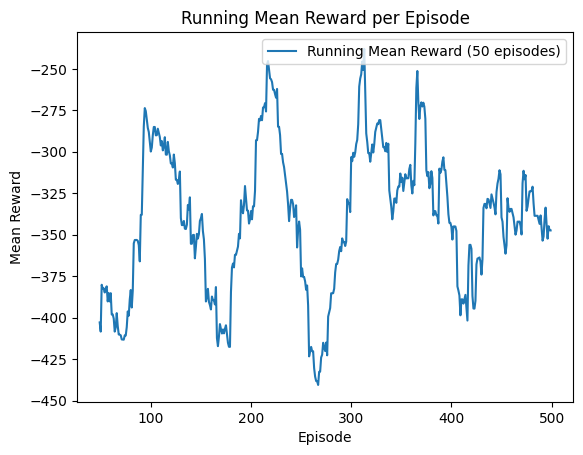

In [55]:
import gymnasium as gym
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

# Define paths
save_path = '/content/drive/MyDrive/pendulum_training/'

# Function to run a simulation using the pre-trained Q-table and collect metrics
def run_simulation(n_eps=500):
    # Create the environment without video recording for metric tracking
    env = gym.make('Pendulum-v1')

    # Load the Q-table
    q_table_path = save_path + 'pendulum.pkl'
    with open(q_table_path, 'rb') as f:
        q = pickle.load(f)

    # Parameters for discretization
    divisions = 15
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    w = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
    a = np.linspace(env.action_space.low[0], env.action_space.high[0], divisions)

    # Metrics storage
    total_rewards = []

    # Run multiple episodes for analysis
    for episode in range(n_eps):
        state = env.reset()[0]
        s_i0 = np.digitize(state[0], x)
        s_i1 = np.digitize(state[1], y)
        s_i2 = np.digitize(state[2], w)
        done = False
        truncated = False
        episode_reward = 0

        while not done and not truncated:
            # Choose the best action based on the Q-table
            action_idx = np.argmax(q[s_i0, s_i1, s_i2, :])
            action = a[action_idx - 1]

            # Take action
            new_state, reward, done, truncated, _ = env.step([action])
            episode_reward += reward
            ns_i0 = np.digitize(new_state[0], x)
            ns_i1 = np.digitize(new_state[1], y)
            ns_i2 = np.digitize(new_state[2], w)

            # Update state indices
            s_i0, s_i1, s_i2 = ns_i0, ns_i1, ns_i2

        # Store metrics for this episode
        total_rewards.append(episode_reward)

    env.close()

    # Calculate the running mean (e.g., over the last 50 episodes)
    window_size = 50
    running_mean = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')

    # Plotting only the running mean
    plt.figure()
    plt.plot(range(window_size - 1, n_eps), running_mean, label="Running Mean Reward (50 episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Mean Reward")
    plt.title("Running Mean Reward per Episode")
    plt.legend()
    plt.show()

# Run the simulation and plot metrics
run_simulation()


I searched and discovered a good agent should on average score between -200 and -500 per episode. It is possible to see it how it always ranges between -250 and -450, confirming the efficacy of the traiining. I decided to compare it now with a random agent

# Random agent

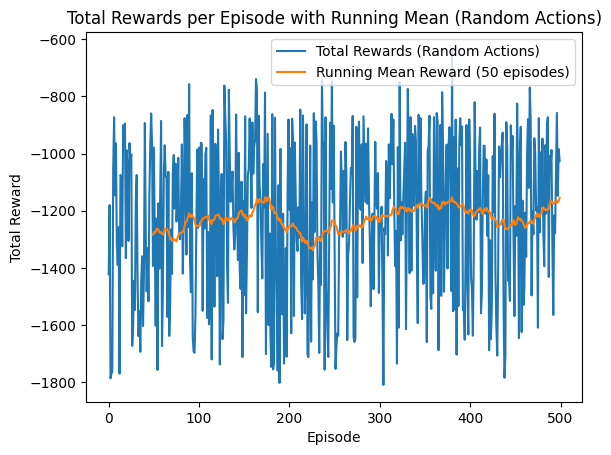

In [54]:
import gymnasium as gym
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

# Define paths
save_path = '/content/drive/MyDrive/pendulum_training/'

# Function to run a simulation using random actions and collect metrics
def run_random_action_simulation(n_eps=500):
    # Create the environment without video recording for metric tracking
    env = gym.make('Pendulum-v1')

    # Parameters for discretization (used here just for consistency with original setup)
    divisions = 15
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    w = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
    a = np.linspace(env.action_space.low[0], env.action_space.high[0], divisions)

    # Metrics storage
    total_rewards = []
    steps_per_episode = []

    # Run multiple episodes for analysis
    for episode in range(n_eps):
        state = env.reset()[0]
        done = False
        truncated = False
        steps = 0
        episode_reward = 0

        while not done and not truncated:
            # Choose a random action
            action = np.random.choice(a)

            # Take action
            new_state, reward, done, truncated, _ = env.step([action])
            episode_reward += reward

            # Update state
            state = new_state
            steps += 1

        # Store metrics for this episode
        total_rewards.append(episode_reward)
        steps_per_episode.append(steps)

    env.close()

    # Calculate the running mean (e.g., over the last 50 episodes)
    window_size = 50
    running_mean = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')

    # Plotting metrics
    plt.figure()
    plt.plot(total_rewards, label="Total Rewards (Random Actions)")
    plt.plot(range(window_size - 1, n_eps), running_mean, label="Running Mean Reward (50 episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Rewards per Episode with Running Mean (Random Actions)")
    plt.legend()
    plt.show()

# Run the simulation and plot metrics
run_random_action_simulation()


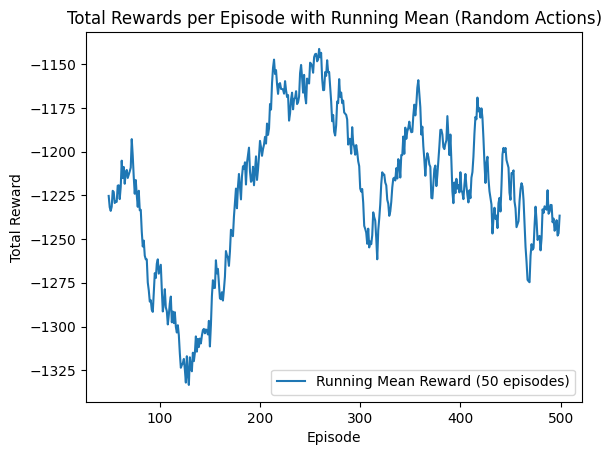

In [56]:
import gymnasium as gym
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

# Define paths
save_path = '/content/drive/MyDrive/pendulum_training/'

# Function to run a simulation using random actions and collect metrics
def run_random_action_simulation(n_eps=500):
    # Create the environment without video recording for metric tracking
    env = gym.make('Pendulum-v1')

    # Parameters for discretization (used here just for consistency with original setup)
    divisions = 15
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    w = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
    a = np.linspace(env.action_space.low[0], env.action_space.high[0], divisions)

    # Metrics storage
    total_rewards = []
    steps_per_episode = []

    # Run multiple episodes for analysis
    for episode in range(n_eps):
        state = env.reset()[0]
        done = False
        truncated = False
        steps = 0
        episode_reward = 0

        while not done and not truncated:
            # Choose a random action
            action = np.random.choice(a)

            # Take action
            new_state, reward, done, truncated, _ = env.step([action])
            episode_reward += reward

            # Update state
            state = new_state
            steps += 1

        # Store metrics for this episode
        total_rewards.append(episode_reward)
        steps_per_episode.append(steps)

    env.close()

    # Calculate the running mean (e.g., over the last 50 episodes)
    window_size = 50
    running_mean = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')

    # Plotting metrics
    plt.figure()
    plt.plot(range(window_size - 1, n_eps), running_mean, label="Running Mean Reward (50 episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Rewards per Episode with Running Mean (Random Actions)")
    plt.legend()
    plt.show()

# Run the simulation and plot metrics
run_random_action_simulation()


In this case the mean ranges between -1325 and -1150.It is possible to notice how the performance is definitely worse than our trained agent, confirming the efficacy of the approach.